# Import Necessary Modules

In [3]:
import twint
import time
import json
import instaloader

import os
from os import path

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

import datetime
import emoji
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# INSTAGRAM
# Installing InstaLoader & Authentication

In [1]:
# !pip install instaloader

In [4]:
# Create an instance of Instaloader class
loader = instaloader.Instaloader()

# Enter your Instagram handle and password
ACCOUNT = 'ilovesmt203'
PASSWORD = 'ilovesmt203!haha'

# Upon successful authentication, you should see a message saying Authentication OK.
# Otherwise, check your login details
try:
    loader.login(ACCOUNT, PASSWORD)
    print("Authentication OK")
except:
    print("Error during authentication")
    
# customise the parameter settings based on your download preference
# configuration 
loader = instaloader.Instaloader(download_pictures=False,
                            download_video_thumbnails=False,
                            download_videos=False,
                            download_comments=True,
                            download_geotags=True,
                            compress_json=False,
                            post_metadata_txt_pattern="")

Authentication OK


# Downloading Posts as JSON files

In [5]:
HASHTAG = "impeachtrump"

# Create a Hashtag instance from a given hashtag name
hashtag = instaloader.Hashtag.from_name(loader.context, HASHTAG)
loaded_posts = hashtag.get_all_posts()

for cnt_post, post in enumerate(loaded_posts):
    # date_created = datetime.datetime.fromtimestamp(post.date_utc)
    if datetime.datetime(2021,1,6) <= post.date_local <= datetime.datetime(2021,2,13):
        try:
            loader.download_post(post, target='#'+hashtag.name)
        except:
            print("\nError in downloading. Process halted.")



Error in downloading. Process halted.
comments json 


# Writing Functions to Extract Information
## Function to extract Individual Post Information (JSON post files into a DataFrame)

In [1]:
def convert_json_posts_to_df(json_path):
    substring = "comment"
    json_files = [filename for filename in os.listdir(json_path) if (filename.endswith('.json') and substring not in filename)]
    post_list = []

    # iterate through the list of JSON files
    for js in json_files:
            
        # open and read each json file
        with open(os.path.join(json_path, js)) as json_file:
            json_text = json.load(json_file)
            #pprint.pprint(json.text)
            
            try:
                # extract Instagram post information
                comment_id = json_text['node']['id']
                user_id = json_text['node']['owner']['id']
                unix_timestamp = json_text['node']['taken_at_timestamp']
                date_time = datetime.datetime.fromtimestamp(unix_timestamp)
                likes_count = json_text['node']['edge_liked_by']['count']
                
                try:
                    comment_raw = json_text['node']['accessibility_caption']
                except:
                    pass
            except:
                pass
        
        post_list.append([comment_id, user_id, date_time, likes_count, comment_raw])
    df = pd.DataFrame(data=post_list, columns=['comment_id', 'user_id', 'date_time', 'likes_count', 'comment_raw'])
    return df

## Function to extract Comments from each Post (comment.JSON files into a DataFrame)

In [21]:
 def convert_comments_to_df(json_path):
    substring = "comment"
    json_files = [filename for filename in os.listdir(json_path) if (filename.endswith('.json') and substring in filename)]
    post_list = []

    # iterate through the list of JSON files
    for js in json_files:
            
        # open and read each json file
        with open(os.path.join(json_path, js)) as json_file:
            json_text = json.load(json_file)
            #pprint.pprint(json.text)
            
            #extract comments from comments.json files
            for comment in json_text:
                comment_id = comment['id']
                user_id = comment['owner']['id']
                date_time = datetime.datetime.fromtimestamp(comment['created_at'])
                likes_count = comment['likes_count']
                comment_raw = comment['text']
                
                post_list.append([comment_id, user_id, date_time, likes_count, comment_raw])

    df = pd.DataFrame(data=post_list, columns=['comment_id', 'user_id', 'date_time', 'likes_count', 'comment_raw'])
    return df

# Extracting Information from Downloaded Files
## #impeachtrump

In [34]:
mypath = "."
folder_name = '#impeachtrump'

json_path1 = f'{mypath}/{folder_name}'
json_path1

'./#impeachtrump'

In [35]:
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', None)

df1 = convert_json_posts_to_df(json_path1)
df1.insert(2, 'platform', 'instagram')
# df1.head()

df2 = convert_comments_to_df(json_path1)
df2.insert(2, 'platform', 'instagram')
df2.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,17916024808583798,3544668418,instagram,2021-02-19 00:52:00,1,Well stated!
1,17874135509220349,30746756357,instagram,2021-02-16 01:55:25,1,😂😂👏
2,17891163556905576,10563354725,instagram,2021-02-12 00:05:16,1,The hand makes it sublime
3,18126510583195827,10563354725,instagram,2021-02-12 00:04:00,1,Missed this one b4 and the band aid too. Too good
4,17912957488603721,9704226,instagram,2021-02-03 22:33:08,1,😜😜😜perfect❣️


In [23]:
frames = [df1, df2]
combined1 = pd.concat(frames) #combining both posts and comments in the same dataframe
combined1.dropna(inplace=True)
combined1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491 entries, 0 to 472
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   491 non-null    object        
 1   user_id      491 non-null    object        
 2   platform     491 non-null    object        
 3   date_time    491 non-null    datetime64[ns]
 4   likes_count  491 non-null    int64         
 5   comment_raw  491 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 26.9+ KB


In [30]:
combined1 = combined1[combined1['comment_raw'].str.startswith("Photo by")==False]
combined1 = combined1[combined1['comment_raw'].str.startswith("Photo shared by")==False]
combined1.head()

# df.to_csv('trump_impeachment_comments.csv')

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,17916024808583798,3544668418,instagram,2021-02-19 00:52:00,1,Well stated!
1,17874135509220349,30746756357,instagram,2021-02-16 01:55:25,1,😂😂👏
2,17891163556905576,10563354725,instagram,2021-02-12 00:05:16,1,The hand makes it sublime
3,18126510583195827,10563354725,instagram,2021-02-12 00:04:00,1,Missed this one b4 and the band aid too. Too good
4,17912957488603721,9704226,instagram,2021-02-03 22:33:08,1,😜😜😜perfect❣️


## #trumpimpeachment

In [24]:
mypath = "."
folder_name = '#trumpimpeachment'

json_path2 = f'{mypath}/{folder_name}'
json_path2

'./#trumpimpeachment'

In [25]:
df3 = convert_json_posts_to_df(json_path2)
df3.insert(2, 'platform', 'instagram')
# df1.head()

df4 = convert_comments_to_df(json_path2)
df4.insert(2, 'platform', 'instagram')
df4.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,17966998288364376,33597388,instagram,2021-02-13 22:54:15,0,Yeah all the black people attacking and murder...
1,17885746028017595,2299592476,instagram,2021-02-13 09:13:03,0,Are you referring to what is happening on the ...
2,17842696493521935,1651100777,instagram,2021-01-22 12:51:37,0,🙌
3,18138103390087013,4147796433,instagram,2021-01-21 06:42:10,1,@debbyanmcfarlane
4,17914123522572768,41693285374,instagram,2021-01-19 20:39:03,0,"I have a proposal for you, talk me to privatel..."


In [26]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   292 non-null    int64         
 1   user_id      292 non-null    object        
 2   platform     292 non-null    object        
 3   date_time    292 non-null    datetime64[ns]
 4   likes_count  292 non-null    int64         
 5   comment_raw  292 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 13.8+ KB


In [27]:
frames = [df3, df4]
combined2 = pd.concat(frames)
combined2.dropna(inplace=True)
combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 291
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   517 non-null    object        
 1   user_id      517 non-null    object        
 2   platform     517 non-null    object        
 3   date_time    517 non-null    datetime64[ns]
 4   likes_count  517 non-null    int64         
 5   comment_raw  517 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 28.3+ KB


In [29]:
combined2 = combined2[combined2['comment_raw'].str.startswith("Photo by")==False]
combined2 = combined2[combined2['comment_raw'].str.startswith("Photo shared by)==False]
combined2.head()

# df.to_csv('trump_impeachment_comments.csv')

,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,2481702515306198095,4028120102,instagram,2021-01-08 07:26:55,2429,These recent events are just a reminder of how...
140,2506215796907085585,44212179522,instagram,2021-02-11 03:10:26,12,Male standing in front of a wall wearing a bla...
0,17966998288364376,33597388,instagram,2021-02-13 22:54:15,0,Yeah all the black people attacking and murder...
1,17885746028017595,2299592476,instagram,2021-02-13 09:13:03,0,Are you referring to what is happening on the ...
2,17842696493521935,1651100777,instagram,2021-01-22 12:51:37,0,🙌


## Merging DataFrames from both hashtags

In [36]:
frames = [combined1, combined2]
combined = pd.concat(frames)
combined.info()

# combined.to_csv('combined_instagram_comments.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 767 entries, 0 to 291
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   comment_id   767 non-null    object        
 1   user_id      767 non-null    object        
 2   platform     767 non-null    object        
 3   date_time    767 non-null    datetime64[ns]
 4   likes_count  767 non-null    int64         
 5   comment_raw  767 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 41.9+ KB


# Conduct Text Preprocessing on 'comment_raw' column

In [97]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald','trump', 'impeachment', 'february', 'one'] # additional stopwords customised based on context 

# iterate through every comment in the dataframe
for text in combined['comment_raw']: 
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", str(text)) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', str(text)) # remove emojis
    text_tokenised = word_tokenize(text) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed.append(text_stopremoved)

#Create new columns
combined['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used for vader analysis (no stopwords removed, but with emojis)
combined['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader analysis (no stopwords removed, but with emojis)
combined['comment_processed'] = comment_processed # to be used for wordcloud (stopwords removed)

combined.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed,vader_score_emoji,vader_score_no_emoji,vader_compound_emoji,vader_compound_no_emoji
0,17916024808583798,3544668418,instagram,2021-02-19 00:52:00,1,Well stated!,Well stated!,Well stated!,"[well, stated]",0.3382,0.3382,0.3382,0.3382
1,17874135509220349,30746756357,instagram,2021-02-16 01:55:25,1,😂😂👏,😂😂👏,,[],0.7003,0.0000,0.7003,0.0000
2,17891163556905576,10563354725,instagram,2021-02-12 00:05:16,1,The hand makes it sublime,The hand makes it sublime,The hand makes it sublime,"[hand, makes, sublime]",0.4939,0.4939,0.4939,0.4939
3,18126510583195827,10563354725,instagram,2021-02-12 00:04:00,1,Missed this one b4 and the band aid too. Too good,Missed this one b4 and the band aid too. Too good,Missed this one b4 and the band aid too. Too good,"[missed, band, aid, good]",0.1779,0.1779,0.1779,0.1779
4,17912957488603721,9704226,instagram,2021-02-03 22:33:08,1,😜😜😜perfect❣️,😜😜😜perfect❣️,perfect,[],0.6369,0.5719,0.6369,0.5719


# Creating Word Clouds
## Basic WordCloud

In [49]:
# create list of words
wordcloud_words = []
for wordlist in combined['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(str(word))

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

'well stated hand makes sublime missed band aid good point miss hope truck lift walk ramps want sure leave behind please take away gladly pay extra weight fee hahahahahahahahahaha good question toxic waste thanks laughter nicely done brett especially appreciate attention detail gave tiny perfect love yea know pretty toxic seriously toxic waste great brett someone fb getting ready virtual moving party moving vans get needed laugh today worried coming week thanks art right garbage garbage bye bye n'

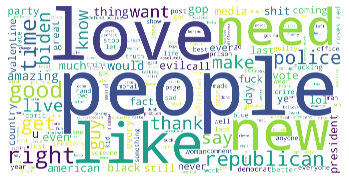

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords_list, background_color="white", width=10000, height=5000).generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("impeachtrump.png")

## With Background Shape

In [59]:
mask = np.array(Image.open("ig_logo.jpg"))
#photos that have values all zero are not recommended
mask

array([[[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       ...,

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[238, 238, 238],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]

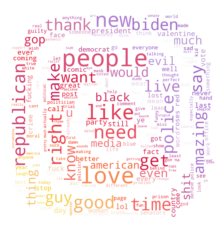

In [60]:
# Generate wordcloud
#method 1 (uses colormap)
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = stopwords_list, mask=mask, color_func = image_colors).generate(wordcloud_string)
# Plot
# plt.figure(figsize=[7,7])
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('instagram_logo_wordcloud.png')

# Vader Sentiment Analysis

In [47]:
def vader_compound_score(sentence): 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

combined['vader_compound_emoji'] = combined['comment_cleaned_emoji'].apply(vader_compound_score) 
combined['vader_compound_no_emoji'] = combined['comment_cleaned_no_emoji'].apply(vader_compound_score) 
combined

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed,vader_score_emoji,vader_score_no_emoji,vader_compound_emoji,vader_compound_no_emoji
0,17916024808583798,3544668418,instagram,2021-02-19 00:52:00,1,Well stated!,Well stated!,Well stated!,"[well, stated]",0.3382,0.3382,0.3382,0.3382
1,17874135509220349,30746756357,instagram,2021-02-16 01:55:25,1,😂😂👏,😂😂👏,,[],0.7003,0.0000,0.7003,0.0000
2,17891163556905576,10563354725,instagram,2021-02-12 00:05:16,1,The hand makes it sublime,The hand makes it sublime,The hand makes it sublime,"[hand, makes, sublime]",0.4939,0.4939,0.4939,0.4939
3,18126510583195827,10563354725,instagram,2021-02-12 00:04:00,1,Missed this one b4 and the band aid too. Too good,Missed this one b4 and the band aid too. Too good,Missed this one b4 and the band aid too. Too good,"[missed, band, aid, good]",0.1779,0.1779,0.1779,0.1779
4,17912957488603721,9704226,instagram,2021-02-03 22:33:08,1,😜😜😜perfect❣️,😜😜😜perfect❣️,perfect,[],0.6369,0.5719,0.6369,0.5719
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,18149271544190128,2220963508,instagram,2021-02-12 23:56:30,5,F her,F her,F her,[f],0.0000,0.0000,0.0000,0.0000
288,17861430776355599,2996004148,instagram,2021-02-12 23:48:20,0,Most of the trump cultists are like him what a...,Most of the trump cultists are like him what a...,Most of the trump cultists are like him what a...,"[cultists, like, coincidence]",0.6597,0.3612,0.6597,0.3612
289,17878659701126348,1816182608,instagram,2021-02-12 23:45:49,3,Eyeing the VP run in 24. Pence Haley,Eyeing the VP run in 24. Pence Haley,Eyeing the VP run in 24. Pence Haley,"[eyeing, vp, run, pence, haley]",0.0000,0.0000,0.0000,0.0000
290,17891593381920969,38523506517,instagram,2021-02-12 23:38:59,16,I’m not a trumper but she has no loyalty to an...,I’m not a trumper but she has no loyalty to an...,I’m not a trumper but she has no loyalty to an...,"[trumper, loyalty, anyone, anything, typical]",-0.5824,-0.5824,-0.5824,-0.5824


In [48]:
combined.to_csv('instagram_comments_processed.csv')

(array([ 39.,  60.,  54.,  43.,  14., 265.,  45.,  90.,  77.,  80.]),
 array([-9.8430e-01, -7.8754e-01, -5.9078e-01, -3.9402e-01, -1.9726e-01,
        -5.0000e-04,  1.9626e-01,  3.9302e-01,  5.8978e-01,  7.8654e-01,
         9.8330e-01]),
 <BarContainer object of 10 artists>)

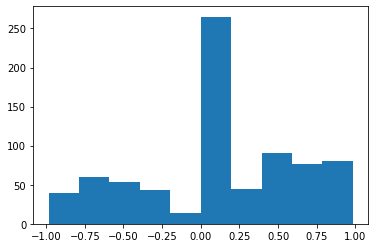

In [61]:
plt.hist(combined.vader_compound_emoji)

# TWITTER
# Scrape data from Twitter using Twint

In [ ]:
# Import packages
import twint
import time
import json

# Set up configurations
c = twint.Config()    
c.Store_csv = True # Store to json
c.Since = "2021-01-06 00:00:00" # Set start date for collection
c.Until = "2021-02-17 00:00:00" # Set end date for collection
c.Retweets = True # Include retweets done by user
c.Lang = "en" # Set language
c.Limit = 100000 # Set tweet limit to 100k 
# c.Near = "Singapore" # Set geograpic location 
c.Search = "trump impeachment" # Set search term
c.Output = "../Data/trump_impeachment_all_counties.csv" # Save output in current directory containing python script

# Run
twint.run.Search(c)

# Prepare basic dataframe for further processing

In [ ]:
# read raw csv file
df5 = pd.read_csv('../Data/trump_impeachment_all_counties.csv')

# combine 'date' and 'time' column into one column
df5['date_time'] = df5[['date', 'time']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# drop records with tweets that are non-english
df5 = df5.drop(df[df.language != 'en'].index)

# drop unnecessary columns
df5.drop(['quote_url', 'thumbnail', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest', 'cashtags', 'timezone', 'created_at', 'retweet', 'near', 'urls', 'photos', 'replies_count', 'retweets_count', 'link', 'video', 'reply_to', 'place', 'conversation_id', 'name', 'username', 'mentions', 'hashtags', 'language', 'date', 'time'], axis='columns', inplace=True)

# rename 'tweet' column to 'comment' to standardise column names
df5.rename(columns={'tweet':'comment_raw', 'id':'comment_id'}, inplace=True)

# insert 'platform' column, and label it 'twitter'
df5.insert(2, 'platform', 'twitter')

# rearrange columns to standardise with Instagram data
cols = list(df.columns)
cols = cols[:3] + [cols[5]] + [cols[4]] + [cols[3]]
df5 = df[cols]
df5


In [ ]:
df5.info()

# Conduct text preprocessing on 'comment_raw' column
Same code used for preprocessing previously for Instagram data

In [ ]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed_list = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald', 'trump', 'impeachment', 'amp', 'live', 'update', 'via'] #additional stopwords customised based on context

# iterate through every comment in the dataframe
for text in df5['comment_raw']:
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", text) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', text) # remove emojis
    text_tokenised = word_tokenize(text_no_emoji) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed_list.append(text_stopremoved)

# create new columns
df5['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used to vader
df5['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader
df5['comment_processed'] = comment_processed_list # to be used for wordcloud
df6 = df6
df6.head()

# Creating WordClouds
## Basic WordCloud

In [ ]:
# create list of words
wordcloud_words = []
for wordlist in df6['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(word)

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=10000, height=5000).generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("trump_impeachment_no_stopwords.png")

## With background shape

In [ ]:
mask = np.array(Image.open("bird2.jpg"))
mask

In [ ]:
# Create custom matplotlib colourbar for better visuals for twitter

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# removes white and green edges in 'ocean' colourbar so that words can be seen
minColor = 0.28
maxColor = 0.75
ocean_t = truncate_colormap(plt.get_cmap("ocean"), minColor, maxColor)

fig = plt.figure()
ax = fig.add_axes([0,0, 1, 0.2])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=ocean_t)

In [ ]:
# Generate wordcloud using colourmap created earlier
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = STOPWORDS, mask=mask, colormap=ocean_t).generate(wordcloud_string)
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('twitter_logo_wordcloud.png')

# Vader Sentiment Analysis

In [ ]:
df6['vader_compound_emoji'] = df6['comment_cleaned_emoji'].apply(vader_compound_score) 

In [ ]:
df6['vader_compound_no_emoji'] = df6['comment_cleaned_no_emoji'].apply(vader_compound_score) 

In [ ]:
df6.head()

In [ ]:
df6.to_csv("trump_impeachment_all_countries_processed.csv")

In [ ]:
plt.hist(df6.vader_score)

# VISUALISATION ANALYSIS

In [ ]:
# Prepare dictionary for later
value_dict = {
    'twitter_positive':0,
    'twitter_neutral':0,
    'twitter_negative':0,
    'instagram_positive':0,
    'instagram_neutral':0,
    'instagram_negative':0,
}

# Read Twitter sentiment values

In [ ]:
df = pd.read_csv('trump_impeachment_all_countries_processed.csv')
df.head()

In [ ]:
for value in df['vader_compound_emoji']:
    if value >= 0.05: 
        value_dict['twitter_positive'] += 1
    elif value <= -0.05: 
        value_dict['twitter_negative'] += 1
    else: 
        value_dict['twitter_neutral'] += 1
print(value_dict)

# Read Instagram sentiment values

In [ ]:
df2 = pd.read_csv('instagram_comments_processed.csv')
df2.head()

In [ ]:
for value in df2['vader_compound_emoji']:
    if value >= 0.05: 
        value_dict['instagram_positive'] += 1
    elif value <= -0.05: 
        value_dict['instagram_negative'] += 1
    else: 
        value_dict['instagram_neutral'] += 1
print(value_dict)

# Create bar graph

In [ ]:
# Twitter
plt.bar(range(3), [value_dict['twitter_positive'], value_dict['twitter_neutral'], value_dict['twitter_negative']])
plt.xticks(range(3), ['twitter_positive', 'twitter_neutral', 'twitter_negative'])
plt.title("Number of comments per sentiment (Twitter)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
num_comments_list = list(value_dict.values())
for i in range(3):
    plt.text(x=i-0.11 , y = num_comments_list[i]+3400 , s=f"{num_comments_list[i]}" , fontdict=dict(fontsize=8))

# plt.savefig('Number of comments per sentiment (Twitter).png')
plt.tight_layout()
plt.show()

In [ ]:
# Instagram
plt.bar(range(3), [value_dict['instagram_positive'], value_dict['instagram_neutral'], value_dict['instagram_negative']])
plt.xticks(range(3), ['instagram_positive', 'instagram_neutral', 'instagram_negative'])
plt.title("Number of comments per sentiment (Instagram)", fontsize = 18, pad=10)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Number of comments",fontsize = 12)
# plt.savefig('Number of comments per sentiment (Twitter).png')
plt.tight_layout()
plt.show()